In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from os import path
from mgefit.find_galaxy import find_galaxy
from mgefit.sectors_photometry import sectors_photometry
from mgefit.mge_fit_sectors import mge_fit_sectors
from mgefit.mge_print_contours import mge_print_contours
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord,ICRS
import astropy.constants as constants
import sympy as sp
import scipy.integrate as spi


对于作业5中的星系，依据fits图像画出其一维的表面亮度轮廓，并计算其星等

• 注意流量单位

• 一维轮廓：

✓椭圆测光：椭圆是等面亮度轮廓，半径沿着长轴方向

✓圆测光: 圆孔径内的平均表面亮度

• 星等：

✓积分（求和）到某个等亮度半径处

✓根据面亮度轮廓模型，积分到无穷远处

由于我在作业5中选了一个faceon的漩涡星系，所以直接用椭圆或者圆获得的结果是不满足sersic profile的..所以就没法拟合sersicindex来积分到无穷远..我采用多高斯拟合，获得星系满足的高斯函数，然后积分到无穷的方法来完成这个作业。

<ipython-input-3-9d65d74e2d28>:4: RuntimeWarning: invalid value encountered in log10
  immag = 22.5 - 2.5*np.log10(img)


 Pixels used: 75952
 Peak Img[j, k]: 1500 1500
 Mean (j, k): 1507.37 1515.07
 Theta (deg): 162.0
 Astro PA (deg): 108.0
 Eps: 0.762
 Major axis (pix): 330.7


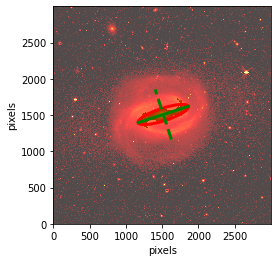

In [3]:
path = './NGC1300_DESI_R'
hdu_list = fits.open(path+'.fits', cache=True)
img = hdu_list[0].data/(0.27*0.27)
immag = 22.5 - 2.5*np.log10(img)
m0 = 0
F0 = 3631
img_ = (10**((m0-immag)/2.5))*F0
imgnan = np.isnan(img_)
img_[imgnan] = 0.0 # Jy/arcsec^2
f = find_galaxy(img_, fraction=0.01, plot=1)

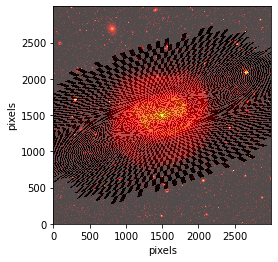

In [4]:
#分割图像为若干个sectors
xcen,ycen,ang,eps = f.xpeak,f.ypeak,f.theta,f.eps
minlevel = 1e-8
s = sectors_photometry(img_, eps, ang, xcen, ycen, minlevel=minlevel,plot=1,n_sectors=101)

Iteration: 0  chi2: 1159.  Nonzero: 9/13
Iteration: 10  chi2: 189.0  Nonzero: 8/13
Iteration: 13  chi2: 188.9  Nonzero: 8/13
Nonzero Gaussians: 8/13
Eliminating not useful Gaussians...
ngauss: 7          chi2: 188.9
ngauss: 6          chi2: 190.1
Starting nonlinear fit...
Iteration: 0  chi2: 190.1  Nonzero: 6/6
Iteration: 2  chi2: 189.0  Nonzero: 6/6
Nonzero Gaussians: 6/6
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 2.18 seconds
  Total Iterations:  13
 Nonzero Gaussians:  6
  Unused Gaussians:  7
 Sectors used in the fit:  101
 Total number of points fitted:  4934
 Chi2: 189.0 
 STDEV: 0.1920 
 MEANABSDEV: 0.1320 
############################################
  Total_Counts   sigma_Pixels     q_obs
############################################
   3.3502e-02        1.959       0.7734
   1.4948e-01        11.14       0.8115
   1.6347e-01      

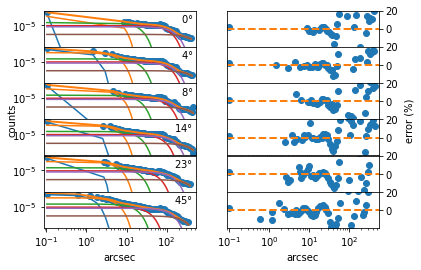

In [5]:
#利用多高斯拟合来拟合面亮度轮廓
ngauss = 13
scale = 0.27
sigmapsf = [0.9/scale/2*np.sqrt(2*np.log(2))]     
normpsf = [1]  # total(normpsf)=1

m = mge_fit_sectors(s.radius, s.angle, s.counts, eps,
                        ngauss=ngauss, sigmapsf=sigmapsf, normpsf=normpsf,
                        scale=scale, plot=1, bulge_disk=0, linear=0)


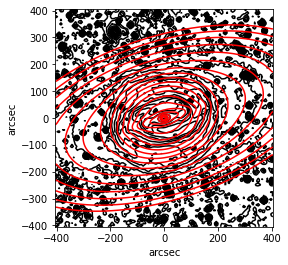

In [19]:
mge_print_contours(img_, ang ,xcen, ycen, m.sol, scale=scale, binning=25,magrange=7,sigmapsf=sigmapsf, minlevel=minlevel)

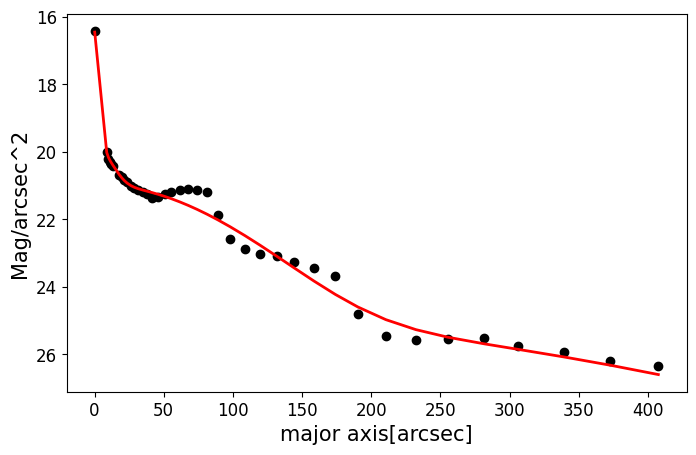

In [9]:
#获得主轴一维轮廓
w = np.nonzero(m.angle == m.sectors[0])[0]
w = w[np.argsort(m.radius[w])]
fluxk = m.counts[w]
fluxk =  - 2.5*np.log10(fluxk)+8.9      # magnitude

fluxfit = m.yfit[w]
fluxfit =  - 2.5*np.log10(fluxfit)+8.9      # magnitude
fig = plt.figure(figsize=(8,5),dpi=100)
ax = fig.add_subplot(1,1,1)   
plt.plot((m.radius[w]*m.scale), fluxk, 'C0o',c='k',linewidth=3)  
plt.plot((m.radius[w]*m.scale), fluxfit, 'C1', linewidth=2, c='r')
plt.xlabel('major axis[arcsec]',size=15)
plt.ylabel('Mag/arcsec^2',size=15)
plt.xticks(size=12)
plt.yticks(size=12)
ax.invert_yaxis()

积分到 25等 约200 arcsec(长轴)

In [32]:
#找到小于200arcsec的点并且求和
index = np.where((m.radius*m.scale)<200)[0]
L_200 = np.sum(m.counts[index])
print("积分到200arcsec的星等为：",- 2.5*np.log10(L_200)+8.9)


积分到200arcsec的星等为： 10.480589620881332


积分到无穷远

In [33]:
#积分每个高斯
Ltot = 0
mges = m.sol
for j in range(len(mges[0])):
    sigma = mges[1,j] 
    q = mges[2,j]
    A = mges[0,j]/(2*np.pi*(sigma**2)*q)
    Ltot = Ltot+2*np.pi*sigma*sigma*A
print("积分到无穷远的星等为：",- 2.5*np.log10(Ltot)+8.9)

积分到无穷远的星等为： 6.726185500235955


#星等没这么亮，可能没注意单位像素的面积

对于所有波段K改正为0mag的天体来说，其SED（f_lamada）可以由什么函数描述

答:

当k改正为0时，天体的辐射相当于是在红移为0处的辐射。假如不考虑星际消光的影响，

对于恒星来说：其各个波段辐射的光应当服从黑体辐射；

对于星团来说：由于同一个星团基本属于同一星族，所以辐射的光也应当基本近似于黑体辐射；

对于星系来说：各个波段辐射的光为不同星族发出的不同温度的光的在该波段的黑体辐射的叠加。

In [ ]:
# 没有理解题目
# # 按照AB星等的定义，K改正为0，fv是常数

In [ ]:
#黑体辐射公式
f_lamada = (2*h*c**2/lamada**5)*(1/(np.exp(h*c/lamada/k/T)-1))

作业9

某标准烛光B波段的星等测量值为25等（内禀绝对星等为-3.0），测量误差为0.1个星等，该天体方向上银河系尘埃的红化E(B-V)=0.2星等（不确定性为0.05个星等），请问该天体的距离为多少，距离测量的不确定性是多少？

Rv=3.1

In [188]:
Rv = 3.1
MB = -3
def getd(mB,Eb_v):
    Av = Rv*Eb_v
    mB0 =  mB-Av
    d = 10**((mB0 - MB+5)/5)/1e6 #Mpc
    return d
dmin = getd(25-0.1,0.2+0.05)
dmax = getd(25+0.1,0.2-0.05)
d = getd(25,0.2)
print('距离为：',d)
print('距离测量不确定度为',(dmax-dmin)/d)

距离为： 2.992264636608183
距离测量不确定度为 0.23540385610898143


#误差是平方求和

作业10

某星系（Ra=180，Dec=-10），观测到其Ha谱线的（真空中）波长被红移到7000A处，在r波段观测到的其AB星等为20等，其光谱的能量分布fλ 在静止波长（5000-7500A）范围内近似为常数，请计算其r波段的绝对星等

In [193]:
Ha0 = 6563 #z=0时Ha的波长
Ha = 7000 #Ha被红移到的波长
H0 = 100 #哈勃常数
c = 3*1e5 #光速
mAB = 20 #视星等
Omega0 = 0.28
z = (Ha-Ha0)/Ha0 #红移

#Mattig公式
d = (1+z)*(c/H0)*(2/((1+z)*Omega0**2))*(Omega0*z+(Omega0-2)*(np.sqrt(1+Omega0*z)-1)) * 1e6 #pc

fAB = 3631*10**(mAB/(-2.5)) #Jy

fAB = fAB/0.6 #除滤光片

mAB_ = -2.5*np.log10(fAB/3631) #转换到消除滤光片影响后的视星等

MAB = mAB - 5*np.log10(d) + 5 #转换到绝对星等


print('rband绝对星等为：',MAB)


rband绝对星等为： -16.56324397482137


In [ ]:
# 0.6为什么会起作用？